In [14]:
import json
import math
import requests
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt

# --- helper functions -----------------------------------------------------

def lonlat_to_tile(lon, lat, zoom):
    """Returns (x, y) tile coordinates for a lon/lat at given zoom."""
    n = 2 ** zoom
    xtile = (lon + 180.0) / 360.0 * n
    lat_rad = math.radians(lat)
    ytile = (1.0 - math.log(math.tan(lat_rad) + 1.0 / math.cos(lat_rad)) / math.pi) / 2.0 * n
    return int(xtile), int(ytile)

def tile_bounds(x, y, zoom):
    """Returns (west, south, east, north) in lon/lat of a tile."""
    n = 2 ** zoom
    west  = x / n * 360.0 - 180.0
    east  = (x + 1) / n * 360.0 - 180.0
    north = math.degrees(math.atan(math.sinh(math.pi * (1 - 2 * y / n))))
    south = math.degrees(math.atan(math.sinh(math.pi * (1 - 2 * (y + 1) / n))))
    return west, south, east, north

def project_to_pixel(lon, lat, bounds):
    """Map lon/lat to pixel coordinates in a 256×256 tile given its bounds."""
    west, south, east, north = bounds
    x_px = (lon - west) / (east - west) * 256
    y_px = (north - lat) / (north - south) * 256
    return x_px, y_px


#Read the geojson file
with open('field_polygons.json', 'r') as f:
    geojson_data = json.load(f)

#Plot the geojson file

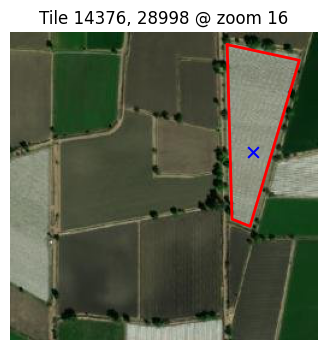

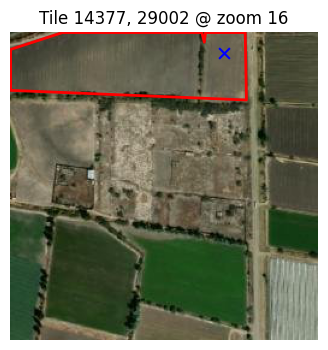

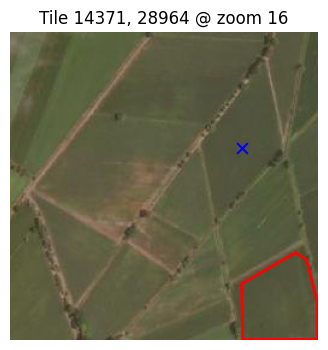

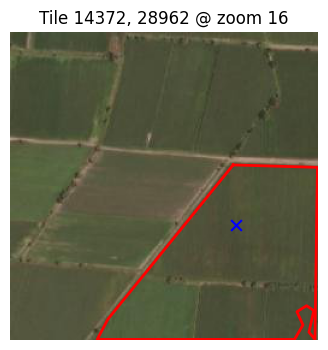

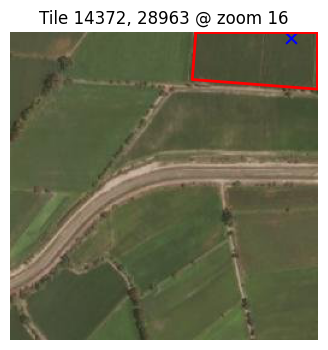

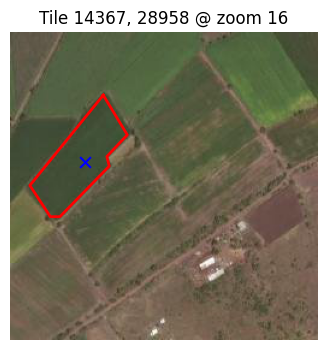

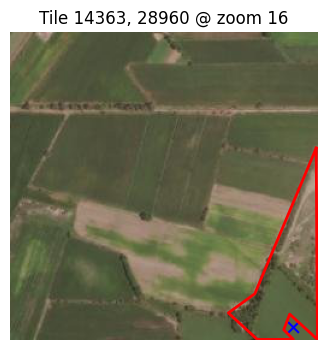

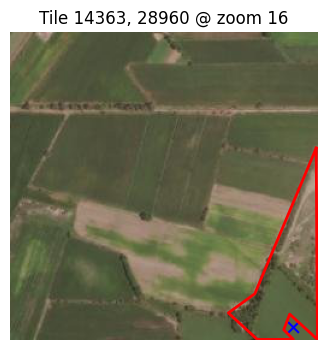

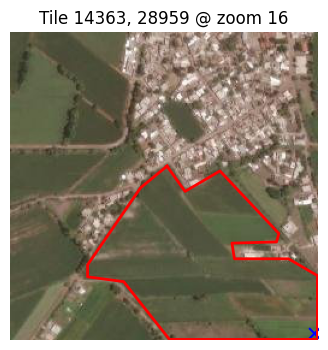

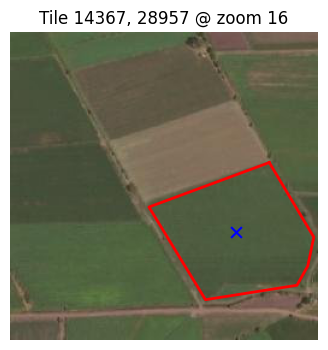

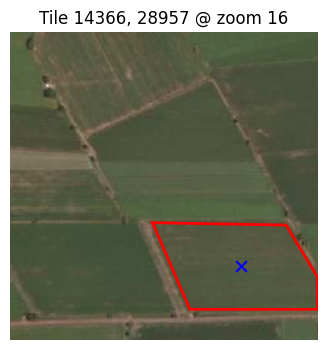

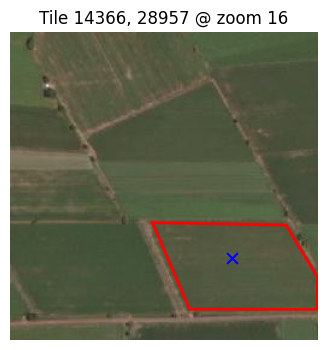

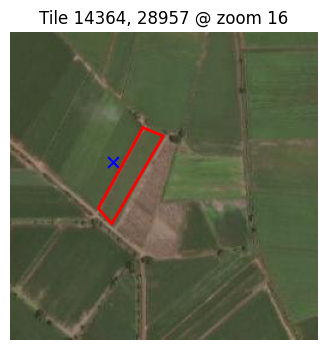

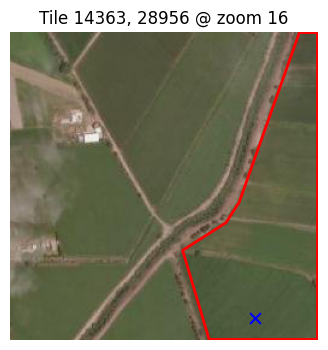

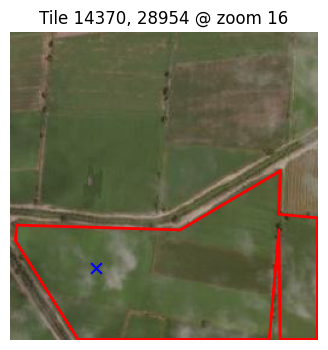

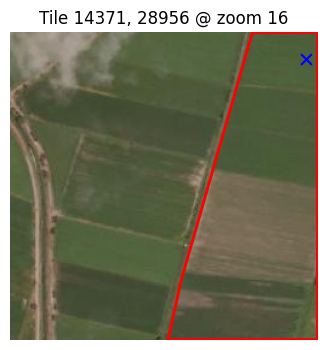

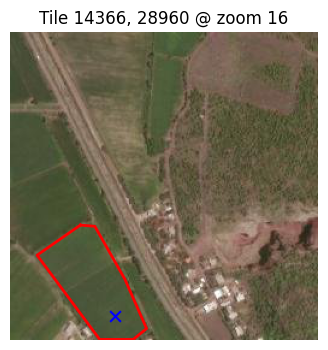

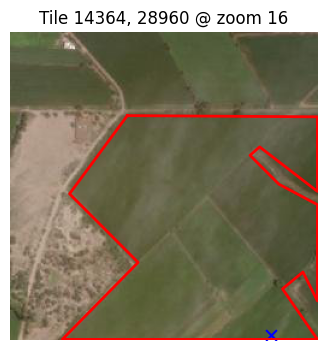

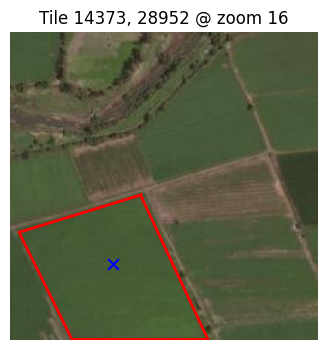

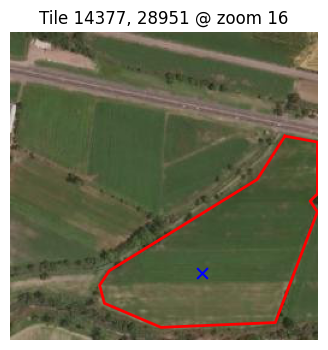

In [15]:
for feat in geojson_data["features"]:
    zoom = 16
    lat = feat["properties"]["query_point"]["lat"]
    lon = feat["properties"]["query_point"]["lon"]

    # compute tile coords
    tx, ty = lonlat_to_tile(lon, lat, zoom)

    # fetch the tile image
    url = f"https://server.arcgisonline.com/ArcGIS/rest/services/" \
          f"World_Imagery/MapServer/tile/{zoom}/{ty}/{tx}"
    resp = requests.get(url)
    tile_img = Image.open(BytesIO(resp.content))

    # compute bounds & project geometry
    bounds = tile_bounds(tx, ty, zoom)
    poly = feat["geometry"]["coordinates"][0]
    poly_px = [project_to_pixel(lon_i, lat_i, bounds) for lon_i, lat_i in poly]
    pt_px   = project_to_pixel(lon, lat, bounds)

    # plot
    fig, ax = plt.subplots(figsize=(4,4))
    ax.imshow(tile_img)
    # polygon outline
    xs, ys = zip(*poly_px)
    ax.plot(xs + (xs[0],), ys + (ys[0],), linewidth=2, linestyle='-', color='red')
    # query point
    ax.scatter(pt_px[0], pt_px[1], marker='x', s=60, color='blue')
    ax.set_title(f"Tile {tx}, {ty} @ zoom {zoom}")
    ax.axis('off')

plt.show()